In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import OrderedDict, deque, Counter
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from datetime import datetime
import pandas as pd

In [2]:
class ImageClassifier(nn.Module):
    def __init__(self, n_classes: int = 10):
        super(ImageClassifier, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.LazyConv2d(32, 3, 1)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('relu2', nn.ReLU()),
            ('maxpool', nn.MaxPool2d(2)),           
            ('flatten', nn.Flatten()),
            ('linear1', nn.LazyLinear(128)),
            ('bn1', nn.LazyBatchNorm1d()),
            ('relu3', nn.ReLU()), 
            ('linear2', nn.LazyLinear(512)),
            ('bn2', nn.LazyBatchNorm1d()),
            ('relu4', nn.ReLU()),
            ('linear3', nn.LazyLinear(128)),
            ('relu5', nn.ReLU()), 
            ('linear4', nn.LazyLinear(64)),
            ('bn3', nn.LazyBatchNorm1d()),
            ('relu6', nn.ReLU()), 
            ('linear5', nn.LazyLinear(32)),
            ('bn4', nn.LazyBatchNorm1d()),
            ('relu7', nn.ReLU()), 
            ('linear8', nn.LazyLinear(n_classes)),
        ]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# I also tried using a standard FC classifier, got similar results
class FullyConnectedClassifier(nn.Module):
    def __init__(self, n_classes: int = 10):
        super(FullyConnectedClassifier, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten()),
            ('linear1', nn.LazyLinear(64)),
            ('relu3', nn.ReLU()), 
            ('linear3', nn.LazyLinear(64)),
            ('relu5', nn.ReLU()), 
            ('linear4', nn.LazyLinear(32)),
            ('relu7', nn.ReLU()), 
            ('linear8', nn.LazyLinear(n_classes)),
        ]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)



In [3]:
batch_size = 256
n_epochs = 10
device = 'mps'
random_input = False
dataset = 'mnist-hard'
classifier = ImageClassifier
learning_rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

Create dataset

In [4]:

if dataset == 'mnist':
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )    
    dataset_train = datasets.MNIST('./mnist-dataset', train=True, download=True, transform=transform)
    dataset_val = datasets.MNIST('./mnist-dataset', train=False, transform=transform)
    
    
elif dataset == 'mnist-hard':
    transform=transforms.Compose([        
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomHorizontalFlip(),      
        transforms.RandomErasing(p=0.75),
        transforms.Lambda(lambda x: x + torch.randn_like(x)),  # adding some gaussian noise
        ]
    )    
    dataset_train = datasets.MNIST('./mnist-dataset', train=True, download=True, transform=transform)
    dataset_val = datasets.MNIST('./mnist-dataset', train=False, transform=transform)
    
elif dataset == 'cifar10':
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )        
    dataset_train = datasets.CIFAR10('./cifar10-dataset', train=True, download=True, transform=transform)
    dataset_val = datasets.CIFAR10('./cifar10-dataset', train=False, transform=transform)
else:
    raise ValueError('unsupported dataset')
    
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


In [5]:
def train_epoch(img_classifier: nn.Module, dataloader_train, optimizer, exit_early: bool):
    img_classifier.train()
    is_finished = False
    recent_accs = deque(maxlen=20)
    t = tqdm(dataloader_train)
    for imgs, labels in t:
        imgs, labels = imgs.to(device=device), labels.to(device=device)
        
        if random_input:
            imgs = torch.randn_like(imgs)
        
        optimizer.zero_grad()
        out = img_classifier(imgs)
        loss = F.cross_entropy(out, labels)
        loss.backward()
        optimizer.step()
        acc = (torch.argmax(out, dim=1) == labels).float().mean().item()
        t.set_description(f'train - loss: {round(loss.item(), 2)}, acc: {round(acc, 2)}')
        recent_accs.append(acc)
        if exit_early and len(recent_accs) == 20 and np.mean(recent_accs) > 0.95:
            is_finished = True
            break
            
    return is_finished

def val_epoch(img_classifier: nn.Module, dataloader_val):
    with torch.no_grad():
        img_classifier.eval()
        t = tqdm(dataloader_val)
        for imgs, labels in t:
            imgs, labels = imgs.to(device=device), labels.to(device=device)
            out = img_classifier(imgs)
            loss = F.cross_entropy(out, labels)
            acc = (torch.argmax(out, dim=1) == labels).float().mean().item()
            t.set_description(f'val - loss: {round(loss.item(), 2)}, acc: {round(acc, 2)}')            


Train network per LR (we will predict the LRs of those networks)

In [6]:
nets = []
for lr in learning_rates:
    torch.manual_seed(0)
    print('current lr:', lr)
    img_classifier = classifier().to(device=device)
    # optimizer = torch.optim.SGD(img_classifier.parameters(), lr=lr, momentum=0.9)
    optimizer = torch.optim.Adam(img_classifier.parameters(), lr=lr)

    for epoch in range(n_epochs):
        is_finished = train_epoch(img_classifier, dataloader_train, optimizer, exit_early=False)
        val_epoch(img_classifier, dataloader_val)  # validation is not really necessary in our case
                
    nets.append(img_classifier)


/Users/benlahav/miniforge3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


current lr: 0.1


val - loss: 0.1, acc: 0.94: 100%|███████████████| 40/40 [00:01<00:00, 26.49it/s]


current lr: 0.05


val - loss: 0.11, acc: 0.94: 100%|██████████████| 40/40 [00:01<00:00, 27.05it/s]


current lr: 0.01


val - loss: 0.15, acc: 0.94: 100%|██████████████| 40/40 [00:01<00:00, 26.86it/s]


current lr: 0.005


val - loss: 0.13, acc: 0.94: 100%|██████████████| 40/40 [00:01<00:00, 27.45it/s]


current lr: 0.001


val - loss: 0.1, acc: 0.94: 100%|███████████████| 40/40 [00:01<00:00, 27.36it/s]


current lr: 0.0005


val - loss: 0.11, acc: 0.94: 100%|██████████████| 40/40 [00:01<00:00, 30.23it/s]


current lr: 0.0001


val - loss: 0.28, acc: 0.94: 100%|██████████████| 40/40 [00:01<00:00, 27.48it/s]


current lr: 5e-05


val - loss: 0.39, acc: 0.88: 100%|██████████████| 40/40 [00:01<00:00, 27.19it/s]


current lr: 1e-05


val - loss: 1.02, acc: 0.75: 100%|██████████████| 40/40 [00:01<00:00, 26.00it/s]


In [7]:
# save checkpoint for future use
current_datetime_str = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
filename = f'nets_{dataset}_{n_epochs}_iter_{current_datetime_str}'
torch.save(nets, f'{filename}.pth')

In [8]:
linear_layer_names = [name for name in list(nets[0].state_dict().keys()) if 'linear' in name and 'weight' in name]

In [9]:

def get_networks_stats(networks: List[nn.Module], linear_layer_names: List[str]) -> Tuple[Dict[str, Dict[float, float]], ...]:
    """
    for each network, get the std and mean of each linear layer
    return: a tuple of dictionaries, first one contains the means, the second one contains the std
    """
    # layer: {lr: mean}
    layer_means = {layer_name: {} for layer_name in linear_layer_names} 
    layer_stds = {layer_name: {} for layer_name in linear_layer_names} 

    for i, net in enumerate(networks):
        for layer_name, param in net.named_parameters():
            if layer_name in linear_layer_names:
                layer_means[layer_name][learning_rates[i]] = param.data.mean().item()
                layer_stds[layer_name][learning_rates[i]] = param.data.std().item()
                
    return layer_means, layer_stds

layer_means, layer_stds = get_networks_stats(nets, linear_layer_names)


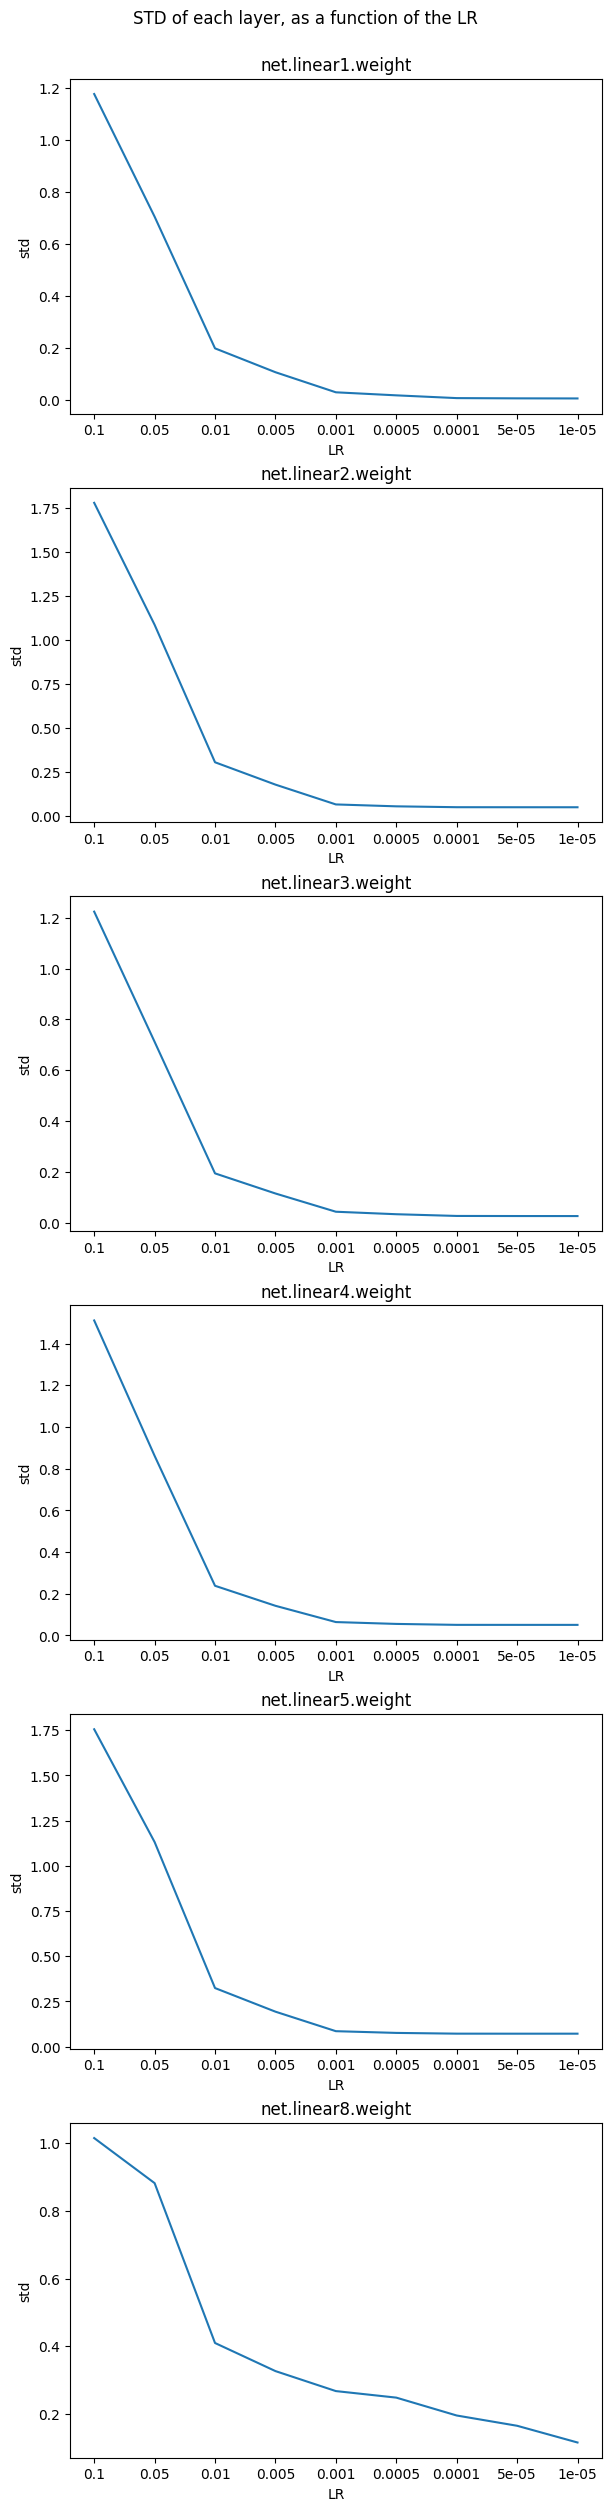

In [10]:
fig, axes = plt.subplots(len(linear_layer_names), figsize=(6, 25), constrained_layout=True)
fig.suptitle('STD of each layer, as a function of the LR\n')
for i in range(len(linear_layer_names)):
    ax = axes[i]
    layer_name = linear_layer_names[i]
    ax.set_title(layer_name)
 
    lr_to_stds = layer_stds[layer_name]
    x = [str(lr) for lr in lr_to_stds.keys()]
    y = list(lr_to_stds.values())
    ax.plot(x, y)
    ax.set_xlabel('LR')
    ax.set_ylabel('std')

plt.savefig(f'{filename}.png')
plt.show()


In [20]:
torch.manual_seed(42)

def reverse_engineer_lr(networks_to_examine: List[nn.Module], reduction: str = 'mean') -> List[float]:
    """
    predict the LR of given networks
    networks_to_examine: networks to reverse-engineer their LR
    reduction: either 'mean' (mean over the differnet layer predictions) or 'vote' (majority vote among the layers)
    return: predicted learning rate for each network
    """
    print('shortly-training networks')
    networks = []
    for lr in learning_rates:
        net = type(networks_to_examine[0])().to(device=device)
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        # optimizer = torch.optim.SGD(img_classifier.parameters(), lr=lr, momentum=0.9)        
        train_epoch(net, dataloader_train, optimizer, exit_early=False)
        networks.append(net)     
                
    _, net_to_examine_layer_stds = get_networks_stats(networks_to_examine, linear_layer_names)
    _, layer_stds = get_networks_stats(networks, linear_layer_names)
    
    predictions = []
    for i in range(len(networks_to_examine)):
        closest_lrs = []
        for layer_name in linear_layer_names:
            lr_to_stds = layer_stds[layer_name]
            lrs = list(lr_to_stds.keys())
            stds = np.array(list(lr_to_stds.values()))

            net_to_examine_std_dict = net_to_examine_layer_stds[layer_name]
            net_to_examine_std = list(net_to_examine_std_dict.values())[i]

            dist_from_net_std = np.abs(stds - net_to_examine_std)
            closest_lr = lrs[dist_from_net_std.argmin()]
            closest_lrs.append(closest_lr)

        # print(closest_lrs)
        if reduction == 'vote':
            closest_lrs_counter = Counter(closest_lrs)
            majority_voted_lr = max(closest_lrs, key=closest_lrs_counter.get)
            predictions.append(majority_voted_lr)
        elif reduction == 'mean':
            predictions.append(np.mean(closest_lrs).item())
        else:
            raise ValueError('invalid reduction option')
        
    return predictions

predictions = reverse_engineer_lr(nets)


/Users/benlahav/miniforge3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


shortly-training networks


train - loss: 1.87, acc: 0.48: 100%|██████████| 235/235 [00:12<00:00, 18.48it/s]


In [21]:
result = np.stack((learning_rates, predictions, np.round(np.array(predictions) / learning_rates, 2)))
pd.DataFrame(result.T, columns=['Original LR', 'Predicted LR', 'Ratio (Predicted/Original)'])

,Original LR,Predicted LR,Ratio (Predicted/Original)
0,0.10000,0.100000,1.00
1,0.05000,0.100000,2.00
2,0.01000,0.030000,3.00
3,0.00500,0.010000,2.00
4,0.00100,0.005167,5.17
5,0.00050,0.002500,5.00
6,0.00010,0.000360,3.60
7,0.00005,0.000133,2.67
8,0.00001,0.000060,6.00
